# Exploratory data analysis on the San Francisco 311 data
Data can be downloaded from: https://data.sfgov.org/City-Infrastructure/311-Cases/vw6y-z8j6/data

In [61]:
%matplotlib inline
%load_ext autoreload
import matplotlib.pyplot as plt

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import numpy as np

## The time window to bucket samples
TIME_RANGE = '24H'

## File path (original data is ~1GB, this is a reduced version with only categories and dates)
#Original file:
#DATAPATH = "SF311_simplified.csv"

#Sample raw data:
DATAPATH = "SF_data/SF-311_simplified.csv"

import pickle as pkl

#with open('data/MSFT_1907_noPreprocessing', 'rb') as f:
with open('data/MSFT_Jul2019_2020', 'rb') as f:
    data = pkl.load(f)
    
data.head()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,headline,text,dtickers,dtopics,time,date
0,"Nintendo Switch, Xbox One & PS4 Prime Day Deal...","Nintendo Switch, Xbox One & PS4 Prime Day Deal...","[{'Id': 'MSFT', 'score': '100'}, {'Id': '7974@...","[{'Id': 'BIZNEWS', 'score': '100'}, {'Id': 'CP...",09:36:00.297000,2019-07-14
1,"Ascent Media Introduces AERO, a New Enterprise...","Ascent Media Introduces AERO, a Ne...","[{'Id': 'MSFT', 'score': '83'}, {'Id': '137866...","[{'Id': 'BIZNEWS', 'score': '100'}, {'Id': 'MS...",08:45:27.795000,2019-07-12
2,"PC, Laptop, Printer, WiFi Router, SSD & Monito...","PC, Laptop, Printer, WiFi Router, SSD & Monito...","[{'Id': 'MSFT', 'score': '100'}, {'Id': 'DELL'...","[{'Id': 'BIZNEWS', 'score': '100'}, {'Id': 'ER...",12:33:00.343000,2019-07-14
3,"Corent, Microsoft, Financial Inclusion Leader ...","Corent, Microsoft, Financial Inclusion Leader ...","[{'Id': 'MSFT', 'score': '100'}, {'Id': 'XYF',...","[{'Id': 'BIZNEWS', 'score': '100'}, {'Id': 'TE...",10:00:00.411000,2019-07-02
4,"I Can't Believe It's Not Butter!(R), Interpoll...",Report Groundbreaking Results at Conclusion of...,"[{'Id': 'MSFT', 'score': '100'}, {'Id': 'UNA@N...","[{'Id': 'BIZNEWS', 'score': '100'}, {'Id': 'TE...",01:11:52.613000,2019-07-04


In [3]:
import spacy
from nltk.tokenize import word_tokenize
from nltk.tokenize import word_tokenize, sent_tokenize
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from string import punctuation
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from sklearn.feature_extraction.text import CountVectorizer
import re
import seaborn as sns
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

print(list(punctuation))
nlp = spacy.load("en_core_web_md") #uncomment the code in the previous cell to download the model


stop_words = set(stopwords.words('english'))

new_words = ["said", "inc", "year", "corp", "also", "net", "may", "com", "percent", "time", "new",
            'link', 'see']
stop_words = list(stop_words.union(new_words)) + list(punctuation)

new_stop_words = []
for stop_word in stop_words:
    new_stop_words.append(stop_word[0].upper() + stop_word[1:])

stop_words += new_stop_words

ps = PorterStemmer()
lem = WordNetLemmatizer()


def pre_process(text, return_tokens=True):
    clean = []
    for sent in sent_tokenize(text, language="french"):

        sent = sent.replace('¬\n', '')
        sent = sent.replace('\n', ' ')
        sent = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",sent)
        sent = re.sub('(\\d|\\W)',' ',sent)
        sent = re.sub(' +', ' ', sent)
        
        #doc = nlp(text)
        #for ent in doc.ents:
        #   # print(ent.text, ent.start_char, ent.end_char, ent.label_)
        #    if ent.label_ in ['DATE', 'MONEY', 'WORK_OF_ART', 'CARDINAL', 'PERCENT']:
        #        text = text.replace(ent.text, ' ')
        sent = re.sub(r'http\S+', '', sent)

        sent = sent.lower()
        words = word_tokenize(sent, language="french")
        temp_words = [word for word in words if word not in stop_words]
        temp_words = [word for word in temp_words if len(word) > 2]
        temp_words = [word for word in temp_words if not word.isupper()]
        temp_words = [word for word in temp_words if '$' not in word]
        temp_words = [word for word in temp_words if '@' not in word]
        temp_words = [word for word in temp_words if 'http' not in word]
        temp_words = [word for word in temp_words if 'www' not in word]
        temp_words = [word for word in temp_words if 'link' not in word]
        temp_words = [lem.lemmatize(word) for word in temp_words if lem.lemmatize(word) not in stop_words]
        
        clean += temp_words
    
    if return_tokens: 
        return clean
    else:
        return ' '.join(clean)

def remove_noise(text):
    while '--' in text:
        text = text[text.index('--')+2:]
    if '. Visit' in text:
        text = text[:text.index('. Visit')]
    if '. visit' in text:
        text = text[:text.index('. visit')]
    while '-0-' in text:
        text = text[:text.index('-0-')]
    while ' SOURCE ' in text:
        text = text[:text.index(' SOURCE ')]
    while 'NOTE:' in text:
        text = text[:text.index('NOTE:')]
    while 'More information can be found' in text:
        text = text[:text.index('More information can be found')]
    while 'CONTACT:' in text:
        text = text[:text.index('CONTACT:')]
    while 'For more information' in text:
        text = text[:text.index('For more information')]
    while 'NOTE TO EDITORS:' in text:
        text = text[:text.index('NOTE TO EDITORS:')]
    while 'can be found at' in text:
        text = text[:text.index('can be found at')]
    while 'View source version' in text:
        text = text[:text.index('View source version')]

    
    return text

stop_words = stop_words + new_stop_words + ['editor', 'contact', 'bloomberg', 'news', 'reporter', 'msft', 'window', 
'information', 'story', 'york', 'prn', 'san', 'bus', 'based', 'first', 
'help', 'today', 'including', 'top', 'site', 'related', 'princeton', 
'reporting', 'use', 'washington', 'click', 'say', 'announced', 
'best', 'yhoo', 'people', 'well', 'make', 'cnp', 'seattle', 
'taginfo', 'highavailability', 'full', 'end', 'using', 'eng',
'est', 'ticker', 'company']

corpus = [pre_process(remove_noise(text), return_tokens=True) for text in data['text'].tolist()]

['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']


In [4]:
corpus[0]

['july',
 'xbox',
 'playstation',
 'nintendo',
 'prime',
 'day',
 'deal',
 'starting',
 'retail',
 'fuse',
 'online',
 'deal',
 'expert',
 'rounded',
 'early',
 'deal',
 'listing',
 'nintendo',
 'prime',
 'day',
 'deal',
 'save',
 'mario',
 'kart',
 'deluxe',
 'nintendo',
 'switch',
 'selling',
 'nintendo',
 'switch',
 'game',
 'sale',
 'amazon',
 'save',
 'legend',
 'zelda',
 'breath',
 'wild',
 'nintendo',
 'switch',
 'selling',
 'nintendo',
 'switch',
 'game',
 'sale',
 'amazon',
 'save',
 'nintendo',
 'labo',
 'variety',
 'kit',
 'diy',
 'kit',
 'let',
 'customizable',
 'cardboard',
 'creation',
 'nintendo',
 'switch',
 'save',
 'nintendo',
 'console',
 'game',
 'bundle',
 'accessory',
 'amazon',
 'prime',
 'day',
 'sale',
 'price',
 'drop',
 'nintendo',
 'switch',
 'nintendo',
 'wii',
 'gear',
 'xbox',
 'one',
 'prime',
 'day',
 'deal',
 'save',
 'xbox',
 'one',
 'two',
 'controller',
 'bundle',
 'save',
 'xbox',
 'one',
 'consolesave',
 'xbox',
 'one',
 'playerunknown',
 'battleg

In [5]:
def get_similarity_matrix(KEYWORD_LIST, kw_list):
    
    similarity_matrix = []
    common_kw_list = nlp(','.join(KEYWORD_LIST))
    new_kw_list = nlp(','.join(kw_list))

    for keyword1 in common_kw_list:
        if keyword1.text not in [',']:
            similarity_vector = []
            for keyword2 in common_kw_list:
                if keyword2.text not in [',']:
                    
                    if keyword1.text == keyword2.text:
                        similarity = 1.0
                        similarity_vector.append(similarity)
                    else:
                        found = False
                        for lookout_keyword in new_kw_list:
                            if lookout_keyword.text == keyword2.text:
                                similarity = lookout_keyword.similarity(keyword1)
                                found = True
                        if found == False:
                            similarity_vector.append(0.0)
                        else:
                            similarity_vector.append(similarity)
                            
            similarity_matrix.append(similarity_vector)
    return np.array(similarity_matrix)

In [6]:
def get_ranked_matrix(matrix_similarity, sorted_matrix):

    rank = 1
    ranked_matrix = np.zeros(shape=(matrix_similarity.shape[0], matrix_similarity.shape[0]))

    for i in range(matrix_similarity.shape[0]):
        for j in range(i, matrix_similarity.shape[0]):
            temp = sorted_matrix[i][j]
            for k in range(matrix_similarity.shape[0]):
                for p in range(k, matrix_similarity.shape[0]):
                    if (matrix_similarity[k][p] != 1.0) and (temp != 1.0):
                        if matrix_similarity[k][p] == temp:
                            ranked_matrix[k][p] = rank + 1

                            rank += 1
                            continue
    return ranked_matrix

In [10]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words=stop_words).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]#Convert most freq words to dataframe for plotting bar plot


In [13]:
KEYWORD_LIST = ['microsoft', 'video', 'cloud', 'team', 'conference', 'security']

In [ ]:
from tqdm import tqdm
rankings = []
dates = []
times = []

for index, text in tqdm(enumerate(corpus), total=len(corpus)):
    try:
        text = ' '.join(text)
        top_words = get_top_n_words([text], n=90)
        
        top_df = pd.DataFrame(top_words)

        top_df.columns=["N-grams", "Freq"]
        kw_list = top_df['N-grams'].tolist()

        matrix_similarity = get_similarity_matrix(KEYWORD_LIST, kw_list)

        sorted_vector = np.flip(np.sort(np.concatenate(matrix_similarity, axis=0)))
        sorted_matrix = np.reshape(sorted_vector, (matrix_similarity.shape[0], matrix_similarity.shape[1]))

        ranked_matrix = get_ranked_matrix(matrix_similarity, sorted_matrix)

        pair_keyword_rankings = []
        for i in range(ranked_matrix.shape[0]):
            for j in range(i, ranked_matrix.shape[0]):
                #if ranked_matrix[i][j] > 0 and ranked_matrix[i][j] < 90:
                    pair_keyword_rankings.append(('-'.join([KEYWORD_LIST[i], KEYWORD_LIST[j]]), ranked_matrix[i][j]))
        
        
        if len(pair_keyword_rankings) > 0:
            rankings.append(pair_keyword_rankings)
            dates.append(data['date'].tolist()[index])
            times.append(data['time'].tolist()[index])
    except:
        pass
        #print(text)
        #print('empty vocabulary; perhaps the documents only contain stop words') 


 31%|███       | 3560/11504 [00:56<02:02, 65.02it/s] 

In [67]:
len(dates), len(rankings)

(1165, 1165)

In [68]:
data_dict = []
for idx, item in enumerate(zip(dates, times, rankings)):
    date, time, ranking = item
    for rank in ranking:
        date_time = str(date).replace('-', '/') + ' ' + str(time)
        line = {'category': rank[0], 'Request Details': 'Article ' + str(idx), 'date': date_time}
        data_dict.append(line)
    
raw_sample_test = pd.DataFrame.from_dict(data_dict)
raw_sample_test = raw_sample_test.sort_values(by="date") # sanity!

from moda.dataprep import raw_to_ts
ts = raw_to_ts(raw_sample_test, date_format="%Y/%m/%d %H:%M:%S")

ts.head()

,category,Request Details,timestamp
date,,,
2019-07-01 01:48:20.055,cloud-team,Article 60,1561945700
2019-07-01 01:48:20.055,microsoft-video,Article 60,1561945700
2019-07-01 01:48:20.055,microsoft-cloud,Article 60,1561945700
2019-07-01 01:48:20.055,microsoft-team,Article 60,1561945700
2019-07-01 01:48:20.055,microsoft-conference,Article 60,1561945700


In [90]:
#!pip install moda

In [91]:
ts.head()

,category,Request Details,timestamp
date,,,
2019-07-01 01:48:20.055,cloud-team,Article 60,1561945700
2019-07-01 01:48:20.055,microsoft-video,Article 60,1561945700
2019-07-01 01:48:20.055,microsoft-cloud,Article 60,1561945700
2019-07-01 01:48:20.055,microsoft-team,Article 60,1561945700
2019-07-01 01:48:20.055,microsoft-conference,Article 60,1561945700


In [92]:
## Some general stats

print("Dataset length: " + str(len(ts)))
print("Min date: " + str(ts.index.get_level_values('date').min()))
print("Max date: " + str(ts.index.get_level_values('date').max()))

print("Total time: {}".format(ts.index.get_level_values('date').max() - ts.index.get_level_values('date').min()))

print("Dataset contains {} categories.".format(len(ts['category'].unique())))



Dataset length: 5977
Min date: 2019-07-01 01:48:20.055000
Max date: 2020-07-30 20:53:09.891000
Total time: 395 days 19:04:49.836000
Dataset contains 15 categories.


#### Next, we decide on the time interval and aggregate items per time and category

In [106]:
from moda.dataprep import ts_to_range
ranged_ts = ts_to_range(ts, time_range=TIME_RANGE)
ranged_ts.head(20)

value
date       category                   
2019-07-01 cloud-conference        4.0
           cloud-security          4.0
           cloud-team              4.0
           conference-security     4.0
           microsoft-cloud         4.0
           microsoft-conference    6.0
           microsoft-security      4.0
           microsoft-team          4.0
           microsoft-video         5.0
           team-conference         2.0
           video-cloud             4.0
           video-conference        6.0
           video-security          2.0
           video-team              4.0
2019-07-02 cloud-conference        0.0
           cloud-security          0.0
           cloud-team              0.0
           conference-security     0.0
           microsoft-cloud         1.0
           microsoft-conference    0.0

In [95]:
#!pip install dfply

In [103]:
#I'm using dfply because I like its functional-like syntax. This can also be done with plain pandas.
#!pip install dfply
from dfply import *

## Remove categories with less than 1000 items (in more than 10 years) or that existed less than 100 days
#min_values = 1000
min_values = 10
min_days = 100



categories = ranged_ts.reset_index() >> group_by(X.category) >> \
    summarise(value = np.sum(X.value),duration_in_dataset = X.date.max()-X.date.min()) >> \
    ungroup() >> \
    mask(X.duration_in_dataset.dt.days > min_days) >> \
    mask(X.value > min_values) >> \
    arrange(X.value,ascending=False)



print("Filtered dataset contains {0} categories,\nafter filtering the small ones that existed less than {1} days or had {2} values of less.".
      format(len(categories),min_days,min_values))

categories.head()

Filtered dataset contains 15 categories,
after filtering the small ones that existed less than 100 days or had 10 values of less.


,category,value,duration_in_dataset
4,microsoft-cloud,775.0,395 days
8,microsoft-video,513.0,395 days
1,cloud-security,481.0,395 days
14,video-team,439.0,394 days
3,conference-security,385.0,394 days


### Most common categories

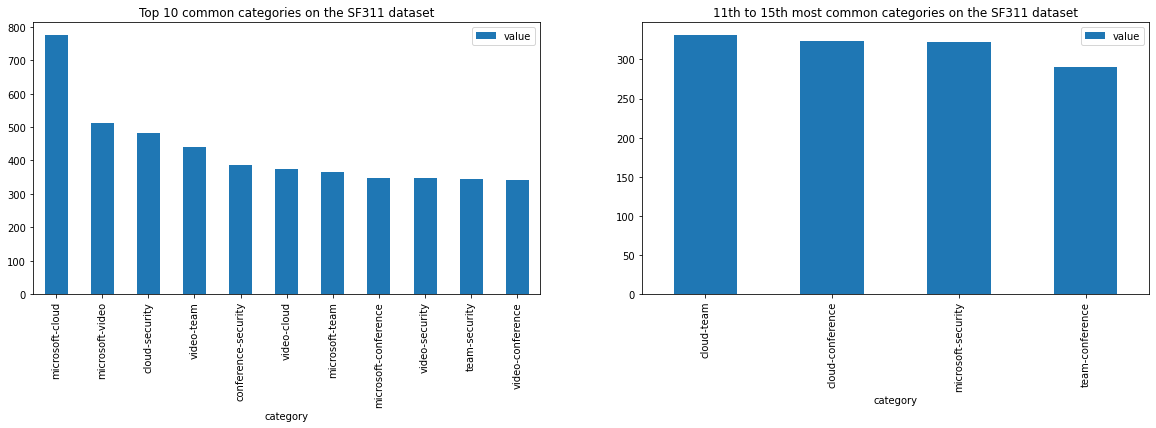

In [104]:
category_names = categories['category'].values
num_categories = len(categories)

major_category_threshold=11
major_categories = category_names[:major_category_threshold]
minor_categories = category_names[major_category_threshold:]

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(5)
fig.set_figwidth(20)

categories[categories['category'].isin(major_categories)].plot(kind='bar',
                                                               x='category',
                                                               y='value',
                                                               title="Top "+str(major_category_threshold-1)+" common categories on the SF311 dataset",
                                                               ax=axes[0])
categories[categories['category'].isin(minor_categories)].plot(kind='bar',
                                                               x='category',
                                                               y='value',
                                                               title=str(major_category_threshold)+"th to "+str(num_categories)+"th most common categories on the SF311 dataset",
                                                               ax=axes[1])

plt.savefig("category_values.png",bbox_inches='tight')

### Change in requests per category from year to year

/home/eboros/anaconda3/envs/python36/lib/python3.6/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/eboros/anaconda3/envs/python36/lib/python3.6/site-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


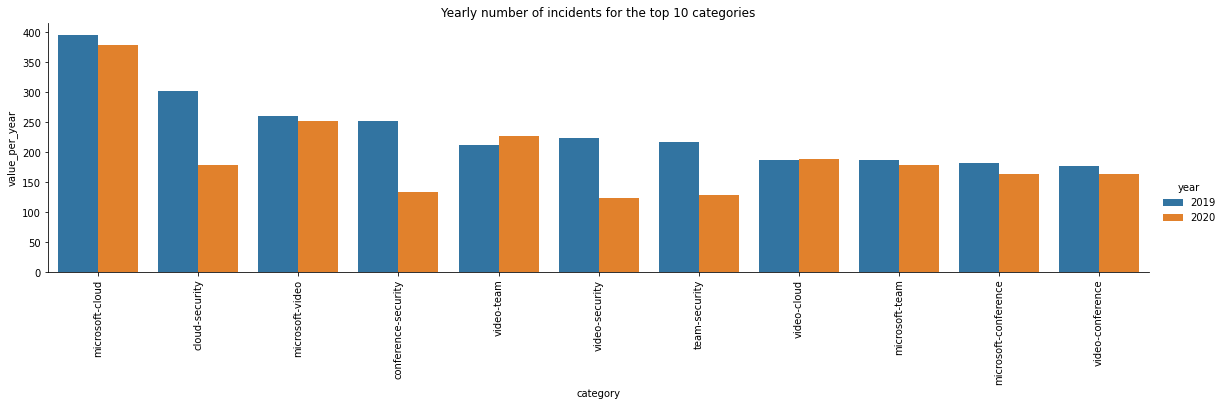

In [75]:
## Calculate the number of values per category per year
categories_yearly = ranged_ts.reset_index() >> mutate(year = X.date.dt.year) >> group_by(X.category,X.year) >> \
    summarise(value_per_year = np.sum(X.value),
              duration_in_dataset = X.date.max()-X.date.min()) >>\
    ungroup() >> \
    mask(X.value_per_year > (min_values/12.0)) >> \
    arrange(X.value_per_year,ascending=False)

import seaborn as sns

major_cats_yearly = categories_yearly[categories_yearly['category'].isin(major_categories)]

g = sns.factorplot(x='category', y='value_per_year', hue='year', data=major_cats_yearly, kind='bar', size=4, aspect=4,legend=True)
g.set_xticklabels(rotation=90)
axes = g.axes.flatten()
axes[0].set_title("Yearly number of incidents for the top "+str(major_category_threshold-1)+" categories")
plt.savefig("yearly_values.png",bbox_inches='tight')

/home/eboros/anaconda3/envs/python36/lib/python3.6/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/eboros/anaconda3/envs/python36/lib/python3.6/site-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Yearly number of incidents for the 11th to 15th categories')

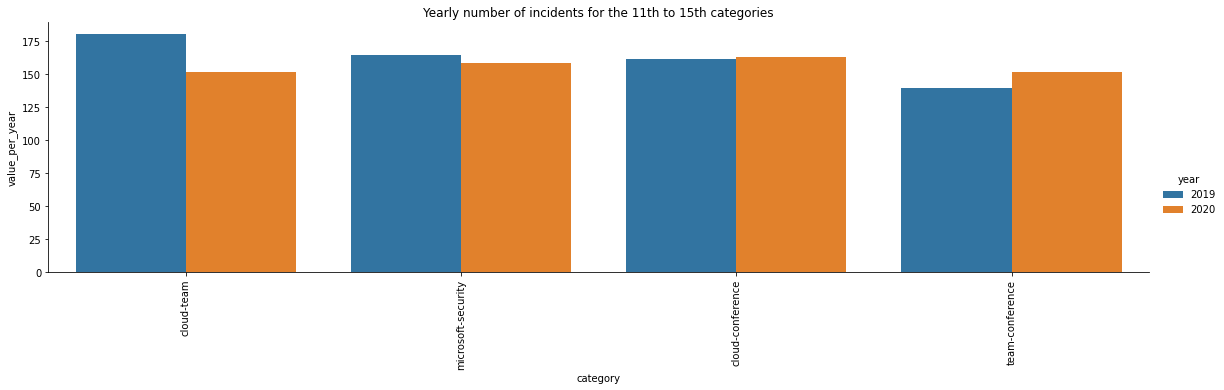

In [76]:
minor_cats_yearly = categories_yearly[categories_yearly['category'].isin(minor_categories)]

g = sns.factorplot(x='category', y='value_per_year', hue='year', data=minor_cats_yearly, kind='bar', size=4, aspect=4,legend=True)
g.set_xticklabels(rotation=90)
axes = g.axes.flatten()
axes[0].set_title("Yearly number of incidents for the "+str(major_category_threshold)+"th to "+str(num_categories)+"th categories")

### Correlation between categories over time

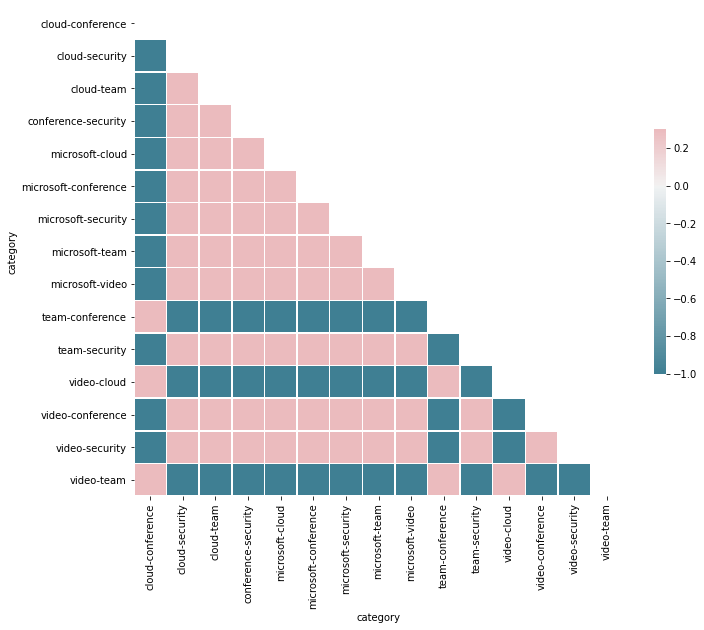

In [78]:
categories_yearly_pivot = categories_yearly.pivot("year", "category", "value_per_year")
categories_yearly_pivot.head()
corr = categories_yearly_pivot.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### One category inspection
#### Example 1: Noise Reports

<AxesSubplot:title={'center':'Number of incidents per 24 hours for video-conference'}, xlabel='date'>

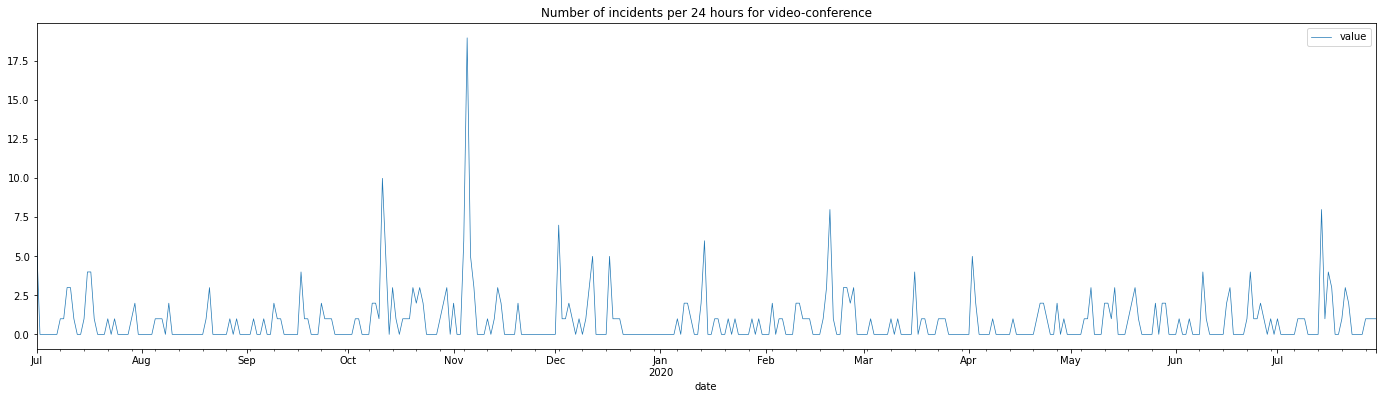

In [88]:
category = "video-conference"
ranged_ts.loc[pd.IndexSlice[:, category], :].reset_index().plot(kind='line',x='date',y='value',figsize=(24,6),linewidth=0.7, 
                          title = "Number of incidents per 24 hours for {}".format(category))

As comparison, let's look at the same time series with different time ranges (30 minutes, 1 hour and 24 hours), only on two months of data

In [84]:
import moda

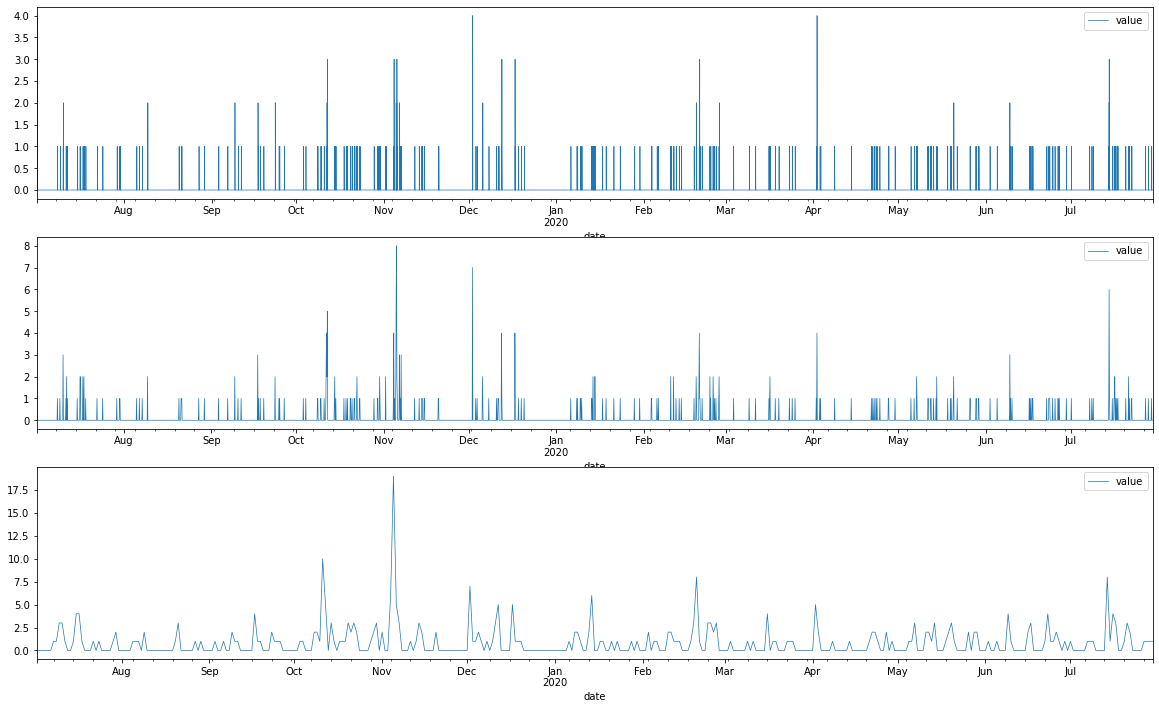

In [89]:
from moda.dataprep import ts_to_range
ranged_ts_3H = ts_to_range(ts, time_range='3H', pad_with_zeros=True)
ranged_ts_30min = ts_to_range(ts, time_range='30min', pad_with_zeros=True)
ranged_ts_24H = ts_to_range(ts, time_range='24H', pad_with_zeros=True)

START = '2019-07-01'
END = '2020-07-30'
category = 'video-conference'
 
fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(20,12))

cleaning_30min = ranged_ts_30min.loc[pd.IndexSlice[:, category], :].reset_index()
a1=cleaning_30min[(cleaning_30min.date > START) & (cleaning_30min.date<=END)].plot(kind='line',x='date',y='value',linewidth=0.7, ax=axes[0])

cleaning_3H = ranged_ts_3H.loc[pd.IndexSlice[:, category], :].reset_index()
a2=cleaning_3H[(cleaning_3H.date > START) & (cleaning_3H.date<=END)].plot(kind='line',x='date',y='value',linewidth=0.7, ax=axes[1])

cleaning_24H = ranged_ts.loc[pd.IndexSlice[:, category], :].reset_index()
a3=cleaning_24H[(cleaning_24H.date > START) & (cleaning_24H.date<=END)].plot(kind='line',x='date',y='value',linewidth=0.7, ax=axes[2])


We can see that there are multiple seasonality factors in this time series. Hourly and weekly patterns are visible on the 30 minute interval time series, and the 3 hours interval time series

## Evaluating different models on the SF 24H data

First, in order to be able to estimate our models, we use [TagAnomaly](https://github.com/Microsoft/TagAnomaly) to tag the points we think are showing trends in the data. Taganomaly can be found here: https://github.com/Microsoft/TagAnomaly
Second, we join the tagged dataset with the time series dataset. Each sample which isn't included in the tagged dataset is assumed to be non-trending (or normal)

In [16]:
## Add labeled data
labels24H = pd.read_csv('SF_data/SF_24H_anomalies_only.csv',usecols=['date','category','value'])
labels24H.date = pd.to_datetime(labels24H.date)

labels24H['label'] = 1
labels24H.sort_values(by='date').head()

,date,category,value,label
52,2018-01-07,Sidewalk or Curb,34,1
41,2018-01-08,Sewer Issues,168,1
8,2018-01-08,Catch Basin Maintenance,19,1
24,2018-01-08,General Request - PUC,38,1
73,2018-01-09,Temporary Sign Request,62,1


In [17]:
# Since we have labels only for 2018, we'll filter out previous years.
ts2018 = ranged_ts[ranged_ts.index.get_level_values(0).year == 2018]
ts2018.head()

value
date       category                         
2018-01-01 311 External Request          0.0
           Abandoned Vehicle            52.0
           Blocked Street or SideWalk   14.0
           Catch Basin Maintenance       1.0
           Color Curb                    2.0

In [18]:
df24H = pd.merge(ts2018.reset_index(),labels24H,how='left',on=['date','category'])
df24H['label'] = np.where(np.isnan(df24H['value_y']),0,1)
df24H = df24H.set_index([pd.DatetimeIndex(df24H['date']),'category'])
df24H = df24H.drop(columns = ['date','value_y']).rename(columns = {'value_x':'value'})
df24H.head()
df24H.to_csv("SF24H_labeled.csv")

In [19]:
len(df24H)

18059

In [20]:
from moda.evaluators import get_metrics_for_all_categories, get_final_metrics
from moda.dataprep import read_data
from moda.models import TwitterAnomalyTrendinessDetector, MovingAverageSeasonalTrendinessDetector, \
    STLTrendinessDetector, AzureAnomalyTrendinessDetector


def run_model(dataset, freq, min_date='01-01-2018', plot=False, model_name='stl', min_value=10,
              min_samples_for_category=100):


    if model_name == 'twitter':
        model = TwitterAnomalyTrendinessDetector(is_multicategory=True, freq=freq, min_value=min_value, threshold=None,
                                                 max_anoms=0.49, seasonality_freq=7)

    if model_name == 'ma_seasonal':
        model = MovingAverageSeasonalTrendinessDetector(is_multicategory=True, freq=freq, min_value=min_value,
                                                        anomaly_type='or',
                                                        num_of_std=3)

    if model_name == 'stl':
        model = STLTrendinessDetector(is_multicategory=True, freq=freq, min_value=min_value,
                                      anomaly_type='residual',
                                      num_of_std=3, lo_delta=0)

    if model_name == 'azure':
        dirname = os.path.dirname(__file__)
        filename = os.path.join(dirname, 'config/config.json')
        subscription_key = get_azure_subscription_key(filename)
        model = AzureAnomalyTrendinessDetector(is_multicategory=True, freq=freq, min_value=min_value,
                                               subscription_key=subscription_key)
    
    # There is no fit/predict here. We take the entire time series and can evaluate anomalies on all of it or just the last window(s)
    prediction = model.predict(dataset, verbose=False)
    raw_metrics = get_metrics_for_all_categories(dataset[['value']], prediction[['prediction']], dataset[['label']],
                                                 window_size_for_metrics=5)
    metrics = get_final_metrics(raw_metrics)
    print(metrics)

    ## Plot each category
    if plot:
        print("Plotting...")
        model.plot(labels=dataset['label'],savefig=False)

    return prediction


ModuleNotFoundError: No module named 'moda.models.azure_anomaly_detection'

In [ ]:
prediction_stl = run_model(df24H,freq='24H',model_name='stl')

In [ ]:
def plot_one_category(category_dataset,model_name='stl'):

    def ts_subplot(plt, series, label):
        plt.plot(series, label=label, linewidth=0.5)
        plt.legend(loc='best')
        plt.xticks(rotation=90)

    plt.subplot(421, )
    ts_subplot(plt, category_dataset['value'], label='Original')
    if 'residual_anomaly' in category_dataset:
        plt.subplot(422)
        ts_subplot(plt, category_dataset['residual_anomaly'], label='Residual anomaly')
    if 'trend' in category_dataset:
        plt.subplot(423)
        ts_subplot(plt, category_dataset['trend'], label='Trend')
    if 'trend_anomaly' in category_dataset:
        plt.subplot(424)
        ts_subplot(plt, category_dataset['trend_anomaly'], label='Trend anomaly')
    if 'seasonality' in category_dataset:
        plt.subplot(425)
        ts_subplot(plt, category_dataset['seasonality'], label='Seasonality')
    
    plt.subplot(426)
    ts_subplot(plt, category_dataset['prediction'], label='Prediction')
    
    if 'residual' in category_dataset:
        plt.subplot(427)
        ts_subplot(plt, category_dataset['residual'], label='Residual')

    plt.subplot(428)
    ts_subplot(plt, category_dataset['label'], label='Labels')
    
    category = category_dataset.category[0]
    
    plt.suptitle("{} results for category {}".format(model_name, category))



In [ ]:
graffiti = prediction_stl.loc[pd.IndexSlice[:, 'Graffiti'], :].reset_index(level='category', drop=False)
fig = plt.figure(figsize=(20,8))
plot_one_category(graffiti,model_name='STL')

The time series in this case is relatively noisy. The model was more conservative than the labeler in this case.

In [ ]:
sewer = prediction_stl.loc[pd.IndexSlice[:, 'Sewer Issues'], :].reset_index(level='category', drop=False)
fig = plt.figure(figsize=(20,8))
plot_one_category(sewer,model_name='STL')

In this case, we missed the first peak as we didn't have enough historical data to estimate it. Let's compare this result to a different model:

In [ ]:
prediction_ma = run_model(df24H,freq=TIME_RANGE,model_name='ma_seasonal')

In [ ]:
sewer2 = prediction_ma.loc[pd.IndexSlice[:, 'Sewer Issues'], :].reset_index(level='category', drop=False)
fig = plt.figure(figsize=(20,8))
plot_one_category(sewer2,model_name='MA seasonal')

This model estimates the trend differently, and found some anomalies on the trend series as well. It too couldn't detect the first peak as it requires some historical data to estimate standard deviation and other statistics.